In [2]:
import gzip
from collections import defaultdict
import random
from tqdm import tqdm
import numpy as np
import ast
import string
from nltk.stem.porter import *
from sklearn.linear_model import LogisticRegression
import pickle

In [3]:
def readJSON(path):
    for l in gzip.open(path, 'rt', encoding="utf8"):
        d = eval(l)
        u = d['userID']
        try:
            g = d['gameID']
        except Exception as e:
            g = None
        yield u,g,d

In [4]:
def parseData(path):
    for l in gzip.open(path, 'rt', encoding="utf8"):
        yield eval(l)
dataset = list(parseData("train_Category.json.gz"))

In [5]:
train = dataset[:165000]
valid = dataset[165000:]

In [6]:
wordCount = defaultdict(int)
totalWords = 0
punct = string.punctuation
stemmer = PorterStemmer()

In [7]:
for d in train:
    t = d['text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        #w = stemmer.stem(w)
        totalWords += 1
        wordCount[w] += 1

In [8]:
counts = [(wordCount[w], w) for w in wordCount]

In [9]:
len(counts)

154889

In [10]:
counts.sort()
counts.reverse()

In [11]:
def feature(datum):
    feat = [0]*len(wordSet)
    t = datum['text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if not (w in wordSet): continue
        feat[wordId[w]] += 1
    feat.append(1)
    return feat

In [12]:
y_train = [d['genreID'] for d in train]
y_valid = [d['genreID'] for d in valid]

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
size_list = [6000 + 200 * n for n in range(16)]
C_list = [0.1, 1, 10]

In [15]:
print(size_list)

[6000, 6200, 6400, 6600, 6800, 7000, 7200, 7400, 7600, 7800, 8000, 8200, 8400, 8600, 8800, 9000]


In [16]:
accuracies = []
for C in C_list:
    for size in tqdm(size_list):
        words = [w[1] for w in counts[:size]]
        wordId = dict(zip(words, range(len(words))))
        wordSet = set(words)
        X_train = [feature(d) for d in train]
        X_valid = [feature(d) for d in valid]
        model = LogisticRegression(C=C)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        accuracy = sum(1 for a, b in zip(y_valid, preds) if a == b) / len(y_valid)
        accuracies.append([accuracy, C, size])

100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [3:17:02<00:00, 738.88s/it]


In [17]:
%store accuracies

Stored 'accuracies' (list)


In [18]:
file_name = 'accuraciesV2.npy'
np.save(file_name, np.array(accuracies))

In [22]:
accuracies = np.array(accuracies)
accuracies[accuracies[:, 0].argsort()][-15:]

array([[7.232e-01, 1.000e+00, 7.600e+03],
       [7.234e-01, 1.000e+01, 7.400e+03],
       [7.234e-01, 1.000e+00, 6.200e+03],
       [7.238e-01, 1.000e+01, 6.000e+03],
       [7.238e-01, 1.000e+00, 6.000e+03],
       [7.238e-01, 1.000e+00, 7.000e+03],
       [7.241e-01, 1.000e-01, 9.000e+03],
       [7.243e-01, 1.000e+01, 6.400e+03],
       [7.245e-01, 1.000e+00, 8.400e+03],
       [7.245e-01, 1.000e+00, 7.400e+03],
       [7.246e-01, 1.000e+00, 6.600e+03],
       [7.257e-01, 1.000e+01, 6.600e+03],
       [7.258e-01, 1.000e+00, 8.000e+03],
       [7.263e-01, 1.000e+00, 8.800e+03],
       [7.278e-01, 1.000e+01, 7.800e+03]])

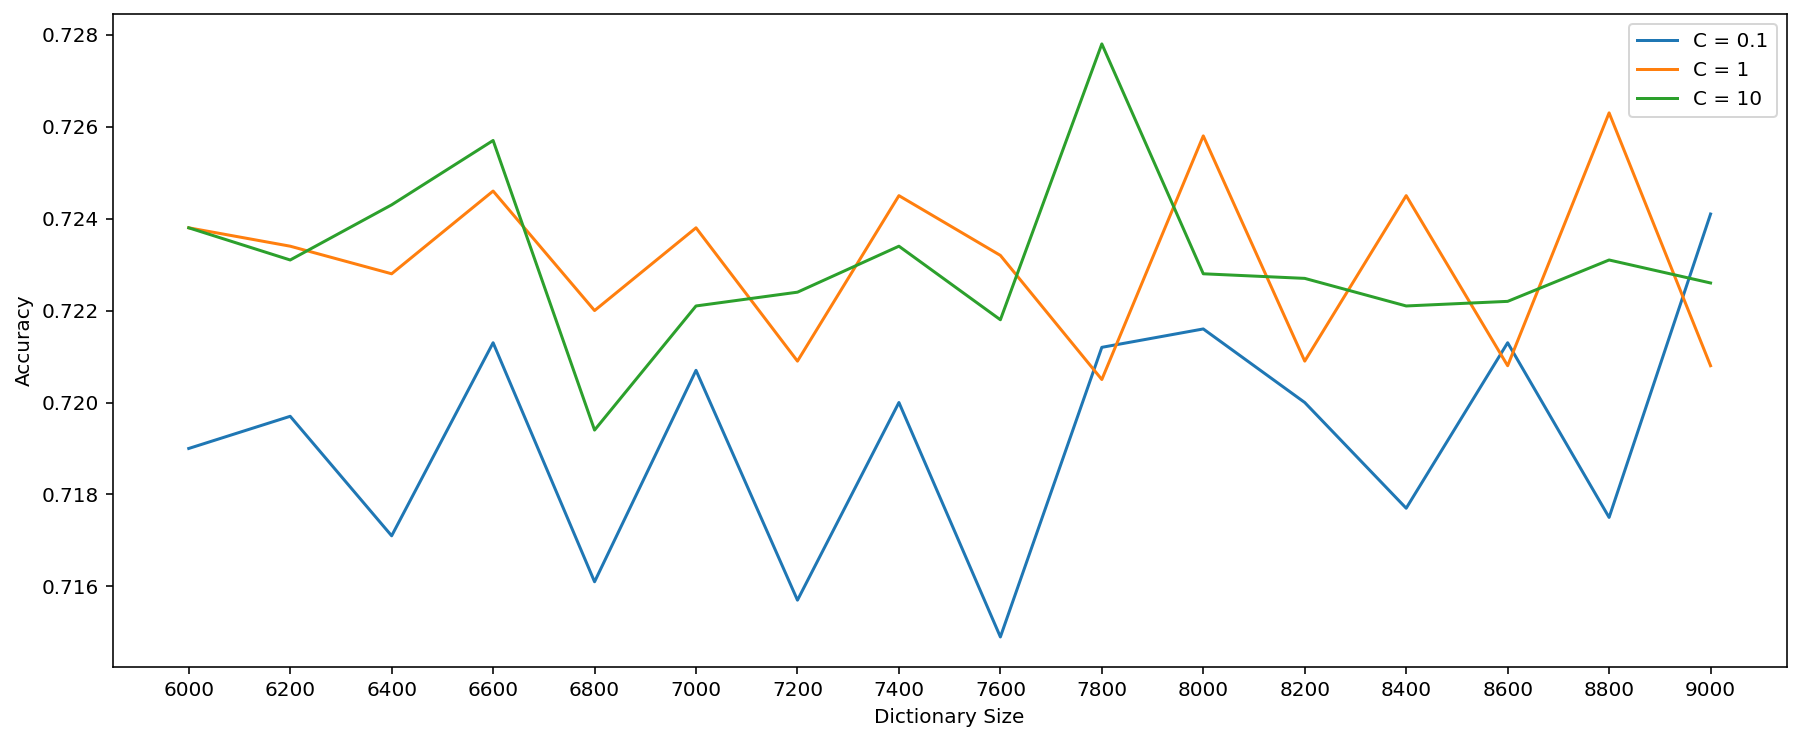

In [23]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.figure(figsize=(15,6))
x1 = [a[2] for a in accuracies if a[1] == 0.1]
y1 = [a[0] for a in accuracies if a[1] == 0.1]
x2 = [a[2] for a in accuracies if a[1] == 1]
y2 = [a[0] for a in accuracies if a[1] == 1]
x3 = [a[2] for a in accuracies if a[1] == 10]
y3 = [a[0] for a in accuracies if a[1] == 10]
size_list = [6000 + 200 * n for n in range(16)]

plt.plot(x1, y1, label='C = 0.1')
plt.plot(x2, y2, label='C = 1')
plt.plot(x3, y3, label='C = 10')
plt.xticks(size_list, [str(s) for s in size_list])
plt.xlabel("Dictionary Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [24]:
words = [w[1] for w in counts[:7800]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)
X_train = [feature(d) for d in train]
model = LogisticRegression(C=10)
model.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
pickle.dump(model, open("model_7800_10.sav", 'wb'))

In [26]:
def saveModel(size, C): 
    words = [w[1] for w in counts[:size]]
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)
    X_train = [feature(d) for d in train]
    model = LogisticRegression(C=C)
    model.fit(X_train, y_train)
    modelname = "model_" + str(size) + "_" + str(C) + ".sav"
    pickle.dump(model, open(modelname, 'wb'))

In [27]:
saveModel(8800, 1)
saveModel(8000, 1)
saveModel(6600, 10)
saveModel(5800, 1)

In [28]:
accuracies1 = np.load("accuracies.npy")
accuracies2 = np.load("accuraciesV2.npy")
accuracies = np.vstack((accuracies1, accuracies2))

test = list(parseData("test_Category.json.gz"))

predictions = open("predictions_Category.txt", 'w')
predictions.write("userID-reviewID,prediction\n")
for d in test:
    predictions.write(d['userID'] + '-' + d['reviewID'] + "," + str(model.predict([feature(d)])[0]) + "\n")

predictions.close()